<a href="https://colab.research.google.com/github/jambacx/Moma-Ai/blob/main/comment_categorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start

### Connect with your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
# install dependencies
!pip install --upgrade -q boto3 awscli sentencepiece transliterate unidecode git+https://github.com/jpmml/sklearn2pmml.git cloudpickle kaleido squarify mlflow

## Import libraries

In [ ]:
import pandas as pd
import unicodedata
import numpy as np
import time
import re
import os
from os.path import exists, join, basename, splitext
import pickle
import cloudpickle
import json
import logging
from tqdm import tqdm

import sentencepiece as spm
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold

from pprint import pprint
from IPython.utils.sysinfo import encoding
from getpass import getpass

import boto3
from boto3.dynamodb.conditions import Attr

import matplotlib.pyplot as plt
import mlflow

from transliterate import translit, get_available_language_codes
from collections import Counter

# download mongolian language trained sentencepiece token
# uncased means trained on text data where all the text has been converted to lowercase
if not exists('mn_uncased.model'):
  !wget -q https://github.com/tugstugi/mongolian-bert/raw/master/sentencepiece/mn_uncased.model
  !wget -q https://github.com/tugstugi/mongolian-bert/raw/master/sentencepiece/mn_uncased.vocab

# if not exists('mn_cased.model'):
#   # download both SentencePiece models: cased and uncased
#   !wget -q https://github.com/tugstugi/mongolian-bert/raw/master/sentencepiece/mn_cased.model
#   !wget -q https://github.com/tugstugi/mongolian-bert/raw/master/sentencepiece/mn_cased.vocab

## Functions

In [ ]:
def cleanup(text):
    '''
    Normalizing raw comments
    '''
    # convert lowercase
    cleaned = text.lower()
    cleaned = " ".join(str(cleaned).split())

    # text font normalization
    cleaned = unicodedata.normalize('NFKC', cleaned)

    # Exclude URLs, HTTP:, HTTPS:
    cleaned = re.sub(r'https?:\/\/[\w!?\/-_~=;.,*&@#$%()\[\]-]+', ' ', cleaned)

    cleaned = re.sub(r"[\d+]", " ", cleaned) #clean digits
    cleaned = re.sub(r'[^\w\s\u0400-\u04FF]', ' ', cleaned) #clean symbols
    # Removing Emojis
    # cleaned = remove_emoji(cleaned)

    # cyrillic to latim convert
    cleaned = translit(cleaned  , 'mn')
    cleaned = slice(cleaned)
    return " ".join(str(cleaned).split())

def slice(sentence):
  words = sentence.split()

  # Filter out words with length equal to 1
  filtered_words = [word for word in words if len(word) > 1]

  # Join the remaining words back into a sentence
  new_sentence = " ".join(filtered_words)
  return new_sentence

def load_dynamodb(TABLE_NAME, profile_name = 'default'):
    # Creating the DynamoDB Table Resource
    session = boto3.Session(region_name="ap-northeast-1",
                            profile_name=profile_name)

    dynamodb = session.resource('dynamodb')
    return dynamodb.Table(TABLE_NAME)

def load_s3(profile_name='default'):
    # Creating the s3 Client
    session = boto3.Session(profile_name=profile_name)
    client = session.client('s3', region_name='ap-northeast-1')
    return client

def inputer(page_name="mobicom",file_name="train"):
  # import dataframe
  path_in = f"/content/drive/MyDrive/fb_comments"
  df = pd.read_excel(f"{path_in}/{page_name}/{page_name}_{file_name}.xlsx",
                    index_col=0,
                    # usecols =["comment_id","comment", "label", "label2"]
                     )
  df.reset_index(inplace=True)
  # df.rename(columns = {df["index"].name : "comment"}, inplace = True)
  df["label"] = df["label"].apply(lambda x: x.lower())
  print(df["label"].value_counts())
  return df

def load_data(s3_bucket = "handlabeldata", file_name = "hand_label.xlsx"):

    temp_file_path = f'/tmp/{file_name}'

    s3 = load_s3()
    s3.download_file(s3_bucket, file_name, temp_file_path)
    # Load the Excel file using Pandas
    df = pd.read_excel(temp_file_path,
                       index_col=0,
                       usecols =["comment", "hand_label", "question","request","hide"])
    df.reset_index(inplace=True)
    df.rename(columns = {"hand_label" : "m1_label"}, inplace = True)
    df["m1_label"] = df["m1_label"].apply(lambda x: x.lower())

    print(df["m1_label"].value_counts())

    return df

def main(df):
  #normalizing comment column
  df['normalized'] = df['comment'].apply(lambda text: cleanup(text))

  # Cut too long or too short comments
  df["length"] = df["normalized"].apply(lambda x: len(x))
  df = df.loc[(df['length'] <= 300) & (df['length'] >= 2)]
  print(f"remove outlier count: {df.shape}")
  # df["length"].value_counts().sort_index().plot()
  # plt.show()

  # dropping same values in comments
  df = df.drop_duplicates(subset=['normalized']).reset_index(drop = True)
  print(f"Dropping duplicated values count: {df.shape}")

  print("Deleted Null comment counts: ", df['comment'].isna().sum())
  df.dropna(subset=['comment'], inplace=True)
  return df

def sp_tokenize(w):
  #Load pretrained model
  return sp.EncodeAsPieces(w)

## Data preprocessing

### AWS config

In [ ]:
# upload your aws credentials (awscli.ini file) to your google drive path as below:
path = "/content/drive/MyDrive/config/awscli.ini"
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path

# test aws credentials work
table = load_dynamodb("posts")
response = table.scan(
    Limit = 1
)
response['Items']

[{'LOVE': Decimal('14'),
  'LIKE': Decimal('40'),
  'message': 'Demon Slayer-ийн фенүүддээ зориулан 45см өндөртэй figure-н эзнийг тодруулах гэж байна',
  'ANGRY': Decimal('0'),
  'created_time': Decimal('1671503451'),
  'page_id': '104059154309977',
  'SAD': Decimal('5'),
  'category': 'default',
  'expire_time': Decimal('1703060377'),
  'HAHA': Decimal('0'),
  'id': '104059154309977_1117097012314435',
  'CARE': Decimal('0'),
  'WOW': Decimal('0'),
  'share_count': Decimal('0')}]

### Input data

In [ ]:
df_1 = load_data(file_name="hand_label_1.xlsx")
df_2 = load_data(file_name="hand_label_2.xlsx")

df = pd.concat([df_1, df_2])
df["m1_label"].value_counts()

neutral     1887
negative    1354
positive    1182
Name: m1_label, dtype: int64
neutral     1751
negative     797
positive     750
Name: m1_label, dtype: int64


neutral     3638
negative    2151
positive    1932
Name: m1_label, dtype: int64

### insert feedback, question, hide label column as m2_label

In [ ]:
df.head()

,comment,m1_label,question,request,hide
0,ёндоо,positive,NaN,NaN,NaN
1,хэзээ,neutral,1.0,NaN,NaN
2,hi аз,positive,NaN,NaN,NaN
3,ха ха,neutral,NaN,NaN,NaN
4,хѳѳѳх,positive,NaN,NaN,NaN


In [ ]:
print(df["question"].value_counts())
print(df["request"].value_counts())
print(df["hide"].value_counts())

1.0    2522
Name: question, dtype: int64
1.0    1101
Name: request, dtype: int64
1.0    1008
Name: hide, dtype: int64


In [ ]:
count = 0
arr = []

for idx, row in df.iterrows():
  if row["hide"] == 1.0:
    count +=1
    arr.append("hide")
  elif row["request"] == 1.0:
    arr.append("request")
  elif row["question"] == 1.0:
    arr.append("question")
  else:
    arr.append("other")

count = {}
for value in arr:
    count[value] = count.get(value, 0) + 1

df["m2_label"] = arr
print(df["m2_label"].value_counts())
df.head()

other       3726
question    2169
hide        1008
request      818
Name: m2_label, dtype: int64


,comment,m1_label,question,request,hide,m2_label
0,ёндоо,positive,NaN,NaN,NaN,other
1,хэзээ,neutral,1.0,NaN,NaN,question
2,hi аз,positive,NaN,NaN,NaN,other
3,ха ха,neutral,NaN,NaN,NaN,other
4,хѳѳѳх,positive,NaN,NaN,NaN,other


In [ ]:
# Randomly choose 3000 neutral samples because the count of neutrals is too high compared to other labels
df_neu = df[df["m1_label"]=="neutral"].sample(3000)
df_rest = df[~(df["m1_label"]=="neutral")]

df = pd.concat([df_neu, df_rest])
df["m1_label"].value_counts()

neutral     3000
negative    2151
positive    1932
Name: m1_label, dtype: int64

### Preprocess

In [ ]:
# test sentencepiece token
df_sub = main(df)

test = "Gertee wifi'tai esvel sar blgn data belgend avdag humuus yu geel beleg awkj udur bolgn data awaad bj bhwde🤓Jhn logictoi bmr yum🥸Beleg ghd hetsuu l yum.Belgyg cn yurn unegui avdg bzd haha"
test = cleanup(test)

sp = spm.SentencePieceProcessor()
sp.Load('mn_uncased.model')
def sp_tokenize(w):
  #Load pretrained model
  return sp.EncodeAsPieces(w)

sp_tokenize(test)[:10]

remove outlier count: (7670, 8)
Dropping duplicated values count: (7517, 8)
Deleted Null comment counts:  0


['▁гэртээ', '▁ви', 'фи', '▁тай', '▁эсвэл', '▁сар', '▁б', 'лг', 'н', '▁дата']

In [ ]:
df_sub.tail()

,comment,m1_label,question,request,hide,m2_label,normalized,length
6899,Uzseen yamar ch goy ungulug kino boloo ve Bas ...,positive,NaN,NaN,NaN,other,үзсээн ямар гоy үнгүлүг кино болоо вэ бас их ч...,175
6900,Суваг солихоор 720-р гараад 1080 болгох гэж тө...,positive,NaN,NaN,NaN,other,суваг солихоор гараад болгох гэж төвөгтэй байс...,152
6901,Hyyhdiin amralt udahgyi bolloo. Kino sanda yad...,negative,NaN,1.0,NaN,request,хyyхдийн амралт үдахгyи боллоо кино санда ядаж...,145
6902,Энэ Voo cinéma чинь гадаадад гардаггүй юмуу. С...,negative,1.0,NaN,1.0,hide,энэ воо cинéма чинь гадаадад гардаггүй юмуу са...,158
6903,❤️🥰💕 💕💕💕Баярлалаа💕💕💕Амьдрал чинь аз жаргалаар ...,positive,NaN,NaN,NaN,other,баярлалаа амьдрал чинь аз жаргалаар дүүрэн бай...,157


## Model training

### Experiment

#### Model config

In [ ]:
# model name
clf_name = "svc" # sgd (Stochastic gradient descent) or svc (Suppor vector classifier)

#choose model type
model_type = "m1_label" # m1_label or m2_label
labels = list(df[model_type].unique())

# define sentencepiece tokenizer
sp = spm.SentencePieceProcessor()
sp.Load('mn_uncased.model')
def sp_tokenize(w):
  #Load pretrained model
  return sp.EncodeAsPieces(w)

# Save artifact to s3 bucket
# s3_bucket = "s3://models-680844809566"
# mlflow.create_experiment(expr_name, s3_bucket)

parameters = {"param_sgd": {"loss": 'hinge',
                            "penalty": 'l2',
                            "alpha": 1e-4,
                            "n_iter_no_change": 5,
                            "random_state": 42,
                            "max_iter": 200
                          },
              "param_svc": {
                            "C": 10,
                            "probability": True
            },
}

params = parameters["param_" + clf_name]

#### Model train

In [ ]:
#tf-idf Tokenizer
df_ready = df_sub.rename(columns=lambda x: x.strip())
df_ready = df_ready.rename(columns = {model_type: "label"})

# show labels
print('labels', df_ready['label'].unique().tolist())

# train data preparing
X_train, X_test, y_train, y_test = train_test_split(df_ready["normalized"], df_ready['label'], test_size=0.1, random_state=42)

df_ready["label"].value_counts()

labels ['positive', 'neutral', 'negative']


neutral     3530
negative    2119
positive    1868
Name: label, dtype: int64

In [ ]:
# train test data vectorizing using sencencepiece tokenizer
vectorizer = TfidfVectorizer(tokenizer = sp_tokenize)

X_train_v = vectorizer.fit_transform(X_train.values)
X_test_v = vectorizer.transform(X_test.values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# We specify a URI of the form s3://<bucket>/<path> to store artifacts in S3.
expr_name = ["SGDclassifier", "SVMclassier"]


#Choose model type
# text_clf = XGBClassifier(**params, verbose=True, early_stopping = True)
text_clf = SVC(**params, verbose=True)
# text_clf = SGDClassifier(**params, verbose=True, early_stopping = True)

# Fit train data into model
text_clf.fit(X_train_v, y_train)

# predict and evaluate predictions
predicted = text_clf.predict(X_test_v)

print(classification_report(y_test, predicted, digits=3))

# Save accuracy to mlflow
accuracy = np.mean(predicted == y_test)

print(accuracy)

[LibSVM]              precision    recall  f1-score   support

    negative      0.769     0.838     0.802       198
     neutral      0.803     0.820     0.812       289
    positive      0.900     0.794     0.844       204

    accuracy                          0.818       691
   macro avg      0.824     0.818     0.819       691
weighted avg      0.822     0.818     0.818       691

0.8176555716353111


In [ ]:
df_test = pd.DataFrame()

df_test["comment"] = X_test
df_test["predicted"] = predicted
df_test["actual"] = y_test

In [ ]:
df_test.head()

,comment,predicted,actual
611,монпаy оноо цүглүүлах yмү нэг үтасний толбор т...,neutral,neutral
2206,амжилт хүсье бөөрөө сурагчилдаа,positive,neutral
6525,хуцалгүй интэрнэтээ янзал гөлгөнүүдээ ачааллаа...,negative,negative
2223,айболат сайн байна уу хүавэй нова сэ гар утасн...,neutral,neutral
2239,айл дэр бүх однүда цүглүүлчд,neutral,neutral


In [ ]:
df_test.to_excel("test_result.xlsx")

#### save model

In [ ]:
path_out = "/content/drive/MyDrive/fb_comments/model/svm_v3.dat"
# path_out = "/content/drive/MyDrive/fb_comments/model/model.pkl"
with open(path_out, 'wb') as f_out:
    cloudpickle.dump((vectorizer, text_clf), f_out)

In [ ]:
BUCKET_NAME = "models-054684516388"
OBJECT_NAME = "svm_v3.dat"

s3 = load_s3()
with open(path_out, "rb") as f:
    s3.upload_fileobj(f, BUCKET_NAME, OBJECT_NAME)

#### Confidence score check

In [ ]:
def load_s3():
    # Creating the s3 Client
    client = boto3.client('s3', region_name = 'ap-northeast-1')
    # resource = boto3.resource('s3', region_name="ap-northeast-1")
    return client

def load_model(s3_bucket = "models-054684516388", model_name = "svm_v2.dat"):

    temp_file_path = f'/tmp/{model_name}'

    s3 = load_s3()
    s3.download_file(s3_bucket, model_name, temp_file_path)
    with open(temp_file_path, 'rb') as f:
        model = pickle.load(f)
    return model

model = load_model()

predicted = model[1].predict(X_test)
boundary_score = model[1].predict_proba(X_test)
for idx, ele in enumerate(predicted[:10]):
  print(ele, round(max(boundary_score[idx]),2))

negative 0.91
neutral 0.62
negative 0.86
positive 0.87
negative 0.66
neutral 0.53
neutral 0.91
negative 0.76
negative 0.88
neutral 0.99


### Gridsearch

#### Gridsearch config

In [ ]:
parameters_grid = {"param_sgd": {
                      # "vect__max_df": (0.5, 0.75, 1.0),
                      # 'vect__max_features': (None, 5000, 10000, 50000),
                      # "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
                      # 'tfidf__use_idf': (True, False),
                      # 'tfidf__norm': ('l1', 'l2'),
                      "clf__max_iter": (10, 50, 100),
                      "clf__alpha": (0.01, 0.001, 0.0001,0.00001),
                      "clf__penalty": ("l2", "elasticnet"),

                   },
                  "param_svc": {
                      "clf__C": [0.1,1, 10, 100],
                      "clf__gamma": [1,0.1,0.01,0.001],
                      "clf__kernel": ['rbf', 'poly', 'sigmoid']
                   },
                   "param_xgb": {
                      "clf__max_depth": (4,6,8,10),
                      "clf__learning_rate": (0.001, 0.01, 0.1),
                      "clf__reg_lambda": (0.01, 0.1, 1),
                      "clf__subsample": (0.6, 0.8, 1),
                      "clf__gamma": (0.05, 0.1, 1)
                   }
                }

params_grid = parameters_grid["param_" + clf_name]

#### XGB classifier

In [ ]:
"""pipeline = Pipeline([('vect', CountVectorizer(tokenizer=sp_tokenize,
                                              lowercase=True,
                                              max_df=0.5,
                                              max_features=None,
                                              ngram_range=(1, 2)
                                              )),
                        ('tfidf', TfidfTransformer(norm='l2',
                                                   use_idf=True)),
                        ('clf', XGBClassifier())])"""
pipeline = XGBClassifier()


# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

# print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)

t0 = time.time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time.time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

NameError: ignored

#### SVM classifier

In [ ]:
start_time = time.time()

grid = GridSearchCV(SVC(), params_grid, refit=True, verbose=2)

grid.fit(X_train,y_train)

end_time = time.time()
timer = end_time - start_time
print(timer)

print(grid.best_estimator_)

In [ ]:
grid_predictions = grid.predict(X_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))

In [ ]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

print(grid.best_estimator_)

## Common words

In [ ]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12,6))
sns.countplot(x='label',data=df)

plt.savefig('label_counts.png')

In [ ]:
def cleanup(text):
    """
    Set confortable range on text length
    :param text: Comment text normalize and clean
    :return Normalized text after clean
    """
    # convert lowercase
    cleaned = text.lower()
    cleaned = " ".join(str(cleaned).split())

    # text font normalization
    cleaned = unicodedata.normalize('NFKC', cleaned)

    # Exclude URLs, HTTP:, HTTPS:
    cleaned = re.sub(r'https?://[\w!?/+\-_~=;.,*&@#$%()\[\]]+', '', cleaned)
    cleaned = re.sub(r"[\d+]", " ", cleaned) #clean digits
    cleaned = re.sub(r'[^\w]', ' ', cleaned) #clean symbols
    # Removing Emojis
    cleaned = remove_emoji(cleaned)

    # cleaned = translit(cleaned  , 'mn')
    return cleaned.strip()

In [ ]:
df

,level_0,index,comment_id,comment,label,normalized,length
0,0,0,1845921442244747_792585018617750,үнэн явцгүй юмаа яасанч их мөнгө зарж сурталчд...,hide,үнэн явцгүй юмаа яасанч их мөнгө зарж сурталчд...,59
1,1,1,1838568336313391_1188628335334350,болохгүйл байгаад байгаа юм даа,negative,болохгүйл байгаад байгаа юм даа,31
2,2,2,1837952846374940_778553833357910,энэ шал худлаа юм шиг ээ гарахгүй л юм бна лээ...,negative,энэ шал худлаа юм шиг ээ гарахгүй л юм бна лээ...,52
3,3,3,1833405360163022_410370834556450,алданги хүүг өгөөд танай байгуулагийг ямарч хо...,negative,алданги хүүг өгөөд танай байгуулагийг ямарч хо...,264
4,4,4,1832117356958489_776061860300163,болохгүй бна лээ ш дээ,negative,болохгүй бна лээ ш дээ,22
...,...,...,...,...,...,...,...
6932,6932,6932,5391643700873653_408799514510641,хэнтий аймаг биндэр суманд авий,question,хэнтий аймаг биндэр суманд авий,31
6933,6933,6933,4659983447373019_4660037474034283,хэд гэж байгаа бэ,question,хэд гэж байгаа бэ,17
6934,6934,6934,4545455795492452_4563718700332828,sumduudad ireh uu архангай эрдэнэмандал,question,сүмдүүдад ирэх үү архангай эрдэнэмандал,39
6935,6935,6935,5334025589968798_1153175582145867,багцаа нэмэгдүүлэхгүйгээр авч болох уу,question,багцаа нэмэгдүүлэхгүйгээр авч болох уу,38


In [ ]:
def commonWords(df):
  with open('/content/drive/MyDrive/fb_comments/raw/custom_stopwords.txt', 'r') as f:
    custom_stopwords = f.read().splitlines()

  df['cleaned'] = df['comment'].apply(lambda x: cleanup(x))
  df["temp_list"] = df['cleaned'].apply(lambda x: [word for word in str(x).split() if word not in custom_stopwords])
  top = Counter([item for sublist in df['temp_list'] for item in sublist])

  temp = pd.DataFrame(top.most_common(100))
  temp.columns = ['common_words','count']
  temp = temp[temp['common_words'].apply(lambda x: len(x) >= 3)]

  custom_stopwords = list(temp.common_words.values)
  print(custom_stopwords)

  return temp

df_temp = commonWords(df)
df_temp.head()

['баярлалаа', 'дата', 'сайн', 'гоё', 'candy', 'зээл', 'гэрээ', 'урамшуулал', 'хурдан', 'нэгж', 'өдөр', 'мөнгө', 'үнэхээр', 'яах', 'сарын', 'үйлчилгээ', 'сүлжээ', 'миний', 'хийж', 'худлаа', 'худалдан', 'байхад', 'хөөрхөн', 'зээлээ', 'өдрийн', 'ашиглаж', 'болдог', 'код', 'карт', 'удаа', 'хаана', 'гэхээр', 'хялбар', 'болдоггүй', 'боломжтой', 'үед', 'ашиглах', 'төлөөд', 'орох', 'салбар', 'дугаараа', 'шдээ', 'байнаа', 'ирэх', 'хугацаа', 'сунгадаг', 'болоод', 'хүмүүс', 'төрсөн', 'алга', 'үнэтэй', 'цаг', 'бэлгээ', 'бнаа', 'шууд', 'өгөх', 'муу', 'үнэн', 'хийсэн', 'өгч', 'төлдөг', 'монгол', 'бсан', 'төлөх', 'газар', 'зөв', 'байнга', 'авалт', 'ирэхгүй', 'өгөөч', 'хүртэл', 'банкны', 'цэнэглэх', 'хийдэг', 'билээ', 'тийм', 'өнөөдөр', 'мобикомын', 'болно', 'маань', 'очиж', 'хүнд', 'хүсэе', 'монпэй', 'өмнө', 'данс', 'байгаад', 'аар', 'сая', 'сард', 'бусад', 'эрдэнэ', 'орохгүй', 'чадахгүй', 'ингэж', 'улам', 'хөдөө']


,common_words,count
0,баярлалаа,378
1,дата,325
2,сайн,245
3,гоё,214
4,candy,187


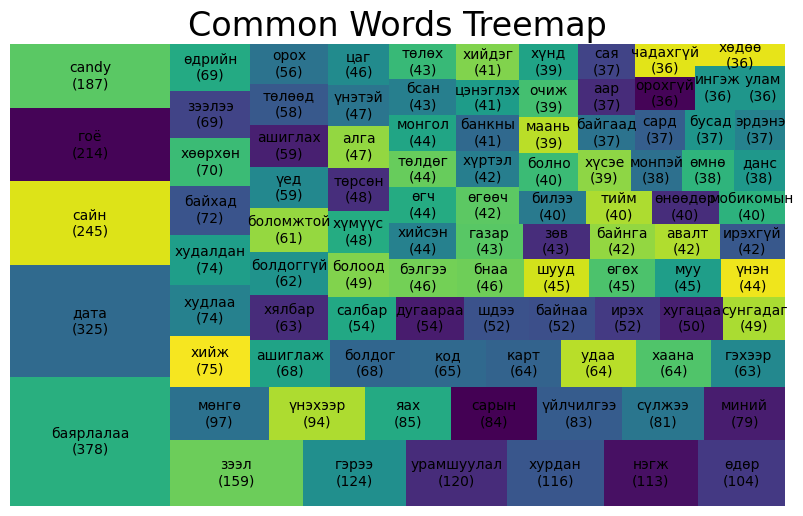

In [ ]:
import matplotlib.pyplot as plt
import squarify

# Define font properties
font = {'family': 'serif',
        'size': 20,
        'weight': 'bold'}

# Generate the treemap
plt.figure(figsize=(10,6))

labels = [f"{word}\n({count})" for word, count in zip(df_temp['common_words'], df_temp['count'])]

squarify.plot(sizes=df_temp['count'], label=labels, alpha=1)

# Set font properties for labels
plt.rc('font', **font)
plt.rc('text', color='black')

# Add labels and title
plt.axis('off')
plt.title("Common Words Treemap")
plt.show()

# plt.savefig("treemaps.png")

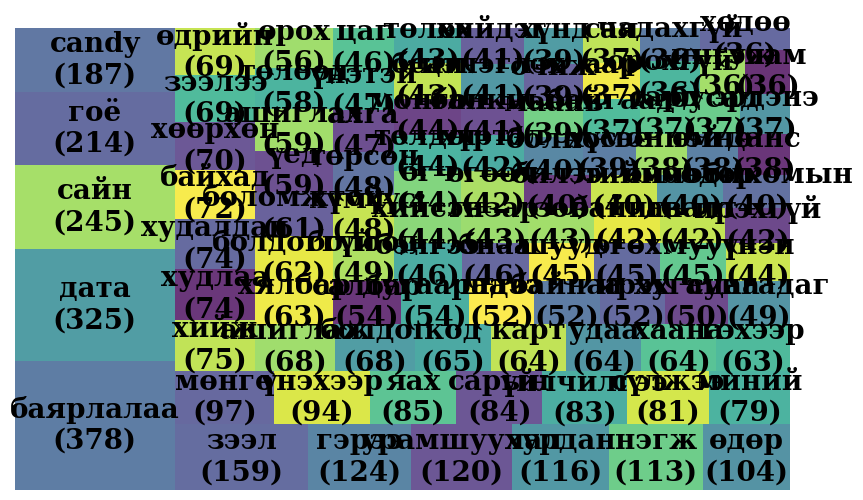

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01\xe0\x08\x06\x00\x00\x005\xd1\xdc\xe4\x00\x00\x009tEXtSoftware\x00Matplotlib version3.7.1, https://matplotlib.org/\xdb\n\x08\x87\x00\x00\x00\tpHYs\x00\x00\x0fa\x00\x00\x0fa\x01\xa8?\xa7i\x00\x00\x08\xc9IDATx\x9c\xed\xd61\x01\x00 \x0c\xc00\xc0\xbf\xe7\xe1\x02\x8e&\nzv\xcf\xcc,\x00\x002\xce\xef\x00\x00\x00\xde2\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\x00\x001\x06\x10\x00 \xc6\x00\x02\x00\xc4\x18@\x00\x80\x18\x03\x08\x00\x10c\x00\x01\x00b\x0c \x00@\x8c\x01\x04\x00\x881\x80\

<Figure size 640x480 with 0 Axes>

In [ ]:
import base64
from io import BytesIO
import io

def imageProcess(df_temp):
  # Define font properties
  font = {'family': 'serif',
          'size': 20,
          'weight': 'bold'}

  # Generate the treemap
  plt.figure(figsize=(10,6))

  labels = [f"{word}\n({count})" for word, count in zip(df_temp['common_words'], df_temp['count'])]

  squarify.plot(sizes=df_temp['count'], label=labels, alpha=0.8)

  # Set font properties for labels
  plt.rc('font', **font)
  plt.rc('text', color='black')

  # Add labels and title
  plt.axis('off')
  # plt.title("Common Words Treemap")
  plt.show()

  # Save the figure to a binary buffer
  plt.savefig('treemap.png')

  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  buf.seek(0)
  image_binary = buf.getvalue()
  print(image_binary)

  # Encode the binary data as base64
  # encoded_data = base64.b64encode(image_binary)
  # # Convert the encoded data to a string
  # image_binary = encoded_data.decode('utf-8')
  # with open('my_image.jpg', 'wb') as f:
  #   f.write(image_binary)

  return image_binary

image_binary = imageProcess(df_temp)

In [ ]:
# import mixed comments
# df = inputer(file_name="mixed")
# df["label"].value_counts()

def inputer(folder_name="data_20230511",file_name="hand_label_1"):
  # import dataframe
  path_in = f"/content/drive/MyDrive/fb_comments"
  df = pd.read_excel(f"{path_in}/{folder_name}/{file_name}.xlsx",
                    index_col=0,
                    usecols =["comment", "hand_label", "question","request","hide"]
                     )
  df.reset_index(inplace=True)
  df.rename(columns = {"hand_label" : "m1_label"}, inplace = True)
  df["m1_label"] = df["m1_label"].apply(lambda x: x.lower())

  print(df["m1_label"].value_counts())
  return df

df_1 = inputer(file_name="hand_label_1")
df_2 = inputer(file_name="hand_label_2")

df = pd.concat([df_1, df_2])
df["m1_label"].value_counts()